# Part IV: Model Evaluation and Comparison
## Best Model Selection
Now, you will evaluate the absolute best model configurations you found
from Part II and Part III on the unseen test set. This provides the most
unbiased measure of how well your models generalize.

From Part II (DinoV2 + MLP): Identify the MLP model (specific architecture and
hyper-parameters) that achieved the best performance on your validation
set.

From Part III (Fine-tuned CNN): select the corresponding CNN model (with its
specific hyper-parameters) that achieved the best performance on your
validation set. 

In [ ]:
%cd "yourpath"
from load_transform import load_data, set_seed
import torch
import random
import torch.nn as nn
from pathlib import Path
from typing import Tuple, List, Optional
from dataclasses import dataclass
from torchvision import models, transforms
from torchvision.models import ResNet34_Weights
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


seed = 42
set_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, val_loader, test_loader, label_to_idx = load_data(batch_size=64, seed=seed, num_workers=4, pin_memory=True)
print(f"Classes: {len(label_to_idx)} | Train: {len(train_loader.dataset)} | "f"Val: {len(val_loader.dataset)} | Test: {len(test_loader.dataset)}")

/opt/bwhpc/common/jupyter/ai/2025-02-20/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/pfs/data6/home/tu/tu_tu/tu_zxoxe46/Practical Deep Learning/Assignment 2
Classes: 10 | Train: 10821 | Val: 2706 | Test: 3382


### DinoV2 MLP Model
We reconstruct the MLP model

In [2]:
# Load the backbone of DinoV2

dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=True).to(device).eval()

Using cache found in /home/tu/tu_tu/tu_zxoxe46/.cache/torch/hub/facebookresearch_dinov2_main
/home/tu/tu_tu/tu_zxoxe46/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/tu/tu_tu/tu_zxoxe46/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/tu/tu_tu/tu_zxoxe46/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
# Load our head model with the best architecture
class DressMLP(nn.Module):
    def __init__(self, input_dim: int = 384, hidden_dims: Tuple[int, ...] = [384, 384, 384], num_classes: int = 10, dropout: float = 0):
        super().__init__()
        layers: List[nn.Module] = []
        in_d = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_d, h, bias=False))
            layers.append(nn.BatchNorm1d(h, momentum=0.01))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            in_d = h
        layers.append(nn.Linear(in_d, num_classes))  # logits
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

### Fine-Tuned CNN
We reconstruct the CNN model

In [4]:
# Minimal configuration for the model
@dataclass
class Config:
    # Model
    num_classes: int = 10
    pretrained_weights = ResNet34_Weights.DEFAULT
    freeze_backbone: bool = False
    
cfg = Config()

In [5]:
class DressNet34(nn.Module):
    def __init__(self, cfg: Config | dict, freeze_backbone: bool = False):
        super().__init__()

        # hyper-param helper
        _get = (lambda k, d=None:
                cfg[k] if isinstance(cfg, dict) else getattr(cfg, k, d))

        self.num_classes = _get("num_classes")
        if self.num_classes is None:
            raise ValueError("`cfg` must define `num_classes`")

        #backbone + new head
        weights   = _get("pretrained_weights", ResNet34_Weights.DEFAULT)
        self.backbone = models.resnet34(weights=weights)

        in_feats  = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_feats, self.num_classes)

        # He initialisation
        nn.init.kaiming_normal_(self.backbone.fc.weight, nonlinearity="relu")
        nn.init.zeros_(self.backbone.fc.bias)

        if freeze_backbone:
            self.freeze()

    # Forward pass
    def forward(self, x):
        return self.backbone(x)

    # freezing
    def freeze(self) -> None:
        for p in self.backbone.parameters():
            p.requires_grad = False
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

    # utils
    def trainable_parameters(self):
        return (p for p in self.parameters() if p.requires_grad)

    def count_params(self, trainable_only: bool = True):
        params = self.trainable_parameters() if trainable_only else self.parameters()
        return sum(p.numel() for p in params)

    def save_weights(self, path: str | Path):
        torch.save(self.state_dict(), Path(path))

    def load_weights(self, path: str | Path, map_location="cpu"):
        self.load_state_dict(torch.load(path, map_location=map_location))

## Test Set Evaluation
For each of your two selected best models:
- Load Saved Weights: You should have saved the weights of your model
checkpoint that corresponded to the best validation performance during
training (due to early stopping). Load these weights back into your model
architecture.

Reading: Saving and Loading Models: https://pytorch.org/tutorials/beginner/
saving_loading_models.html (Focus on saving/loading state_dict). 

In [6]:
def load_model_checkpoint(model, path):
    ckpt = torch.load(path, map_location=device)
    if isinstance(ckpt, dict) and "model_state" in ckpt:
        model.load_state_dict(ckpt["model_state"])
    else:
        model.load_state_dict(ckpt)
    model.to(device)
    model.eval()
    return model

DressDino = DressMLP(input_dim=384, hidden_dims=[384, 384, 384], num_classes=10).to(device)
DressDino = load_model_checkpoint(DressDino, "best_dinov2.pt")

DressNet = DressNet34(cfg, freeze_backbone=False).to(device)
DressNet = load_model_checkpoint(DressNet, "best_resnet.pt")

## Metrics
- Overall Accuracy: Calculate the overall accuracy on the test set.

In [7]:
# Names for the classes
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
class_names = [idx_to_label[i] for i in range(len(idx_to_label))]

# Test accuracy for DINO
all_preds_dino = []
all_labels_dino = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        feats  = dino(images) # first go through DINO
        logits = DressDino(feats) # now our model
        preds  = logits.argmax(dim=1).cpu().numpy()
        all_preds_dino.extend(preds)
        all_labels_dino.extend(labels.numpy())

acc_dino = accuracy_score(all_labels_dino, all_preds_dino)
print(f"DinoV2 Test Accuracy: {acc_dino:.4f}")


# DressNet34
all_preds_cnn = []
all_labels_cnn = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = DressNet(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds_cnn.extend(preds)
        all_labels_cnn.extend(labels.numpy())
acc_cnn = accuracy_score(all_labels_cnn, all_preds_cnn)
print(f"Full-Fine-Tuned 'Dressnet' Test Accuracy: {acc_cnn:.4f}")

DinoV2 Test Accuracy: 0.6428
Full-Fine-Tuned 'Dressnet' Test Accuracy: 0.6360


We can see that the classification accuracy with respect to the test data set that we isolated in the first part of the assignment is higher in the DinoV2 implementation than the "DressNet" model.

- Confusion Matrix: Generate a confusion matrix. This is a table where rows
represent true labels and columns represent predicted labels. The diagonal
elements show correct classifications, and off-diagonal elements show
misclassifications. It's very useful for seeing which specific classes are
being confused with each other. 

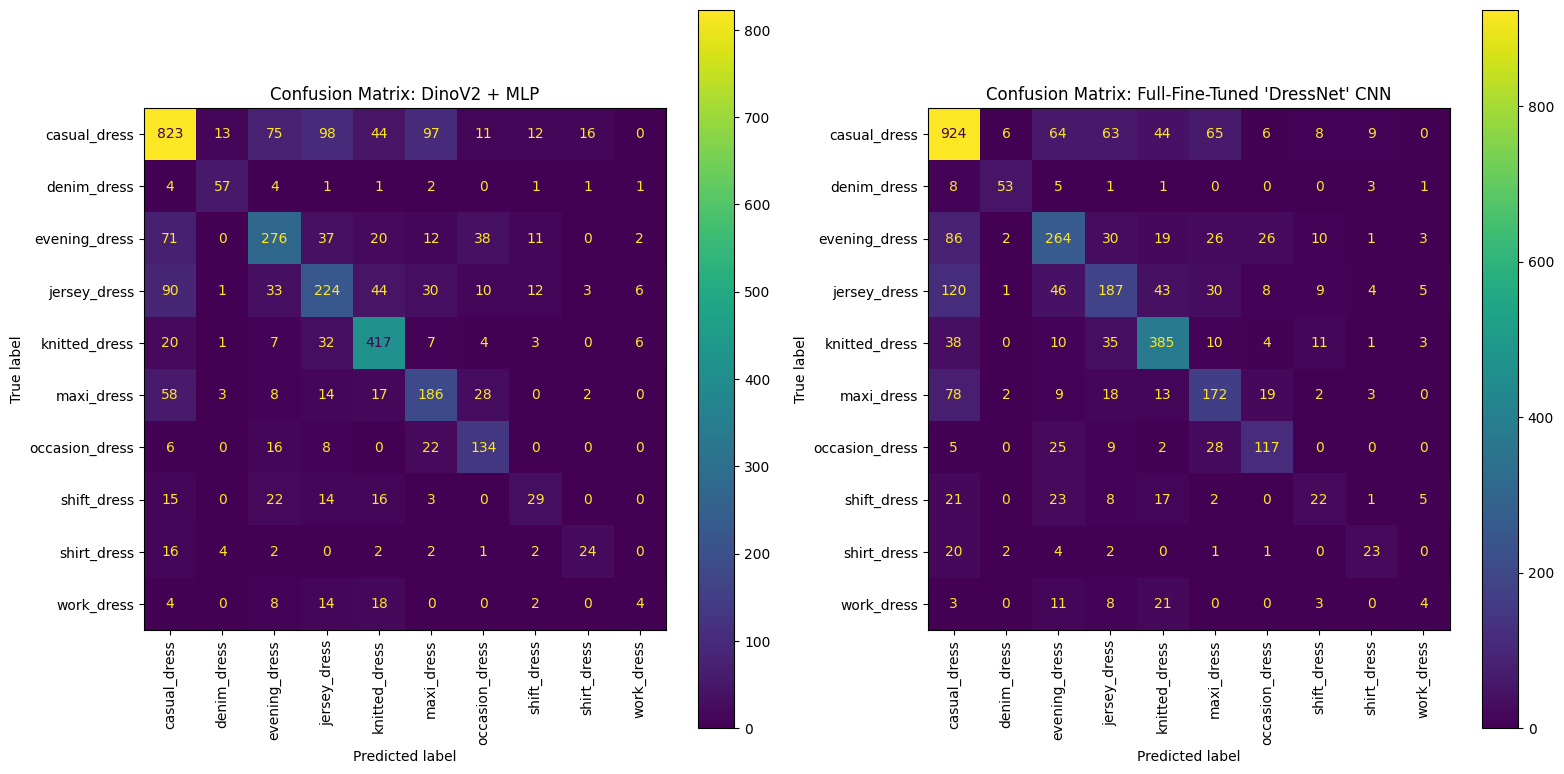

In [8]:
# Compute confusion matrices
cm_dino = confusion_matrix(all_labels_dino, all_preds_dino)
cm_cnn = confusion_matrix(all_labels_cnn, all_preds_cnn)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot DinoV2 + MLP confusion matrix
disp_dino = ConfusionMatrixDisplay(confusion_matrix=cm_dino, display_labels=class_names)
disp_dino.plot(ax=axes[0], xticks_rotation='vertical')
axes[0].set_title("Confusion Matrix: DinoV2 + MLP")

# Plot Fine-Tuned CNN confusion matrix
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_names)
disp_cnn.plot(ax=axes[1], xticks_rotation='vertical')
axes[1].set_title("Confusion Matrix: Full-Fine-Tuned 'DressNet' CNN")

plt.tight_layout()
plt.show()

From the confusion matrix we can see which elements from the test dataset were correctly or incorrectly classified by each model. At simple glance we can see that both classifiers perform in a very similar way following very similar patterns. The only clear differential pattern that we can see is that the Fine-Tuned net tends to over-classify into the biggest class, which labels the casual dresses. From this exploration we can see that the dataset is quite challenging by itself due to the imbalance.

## Qualitative Analysis (Error Analysis): 
Looking at specific examples can provide insights beyond quantitative
metrics. For each of the two final models:
- Randomly sample and display (show the image, its true label, and the
model's predicted label):

In [ ]:
set_seed(seed)

# Helper
# Undo normalization to see better
def denorm(img, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img.clamp(0, 1)

# get predictions
def collect_preds(model, loader, feature_extractor=None):
    imgs, y_true, y_pred = [], [], []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            imgs.extend(x.clone().cpu())
            feats = x.to(device)
            if feature_extractor is not None: # para Dino
                feats = feature_extractor(feats)
            logits = model(feats)
            preds = logits.argmax(1).cpu()
            y_true.extend(y)
            y_pred.extend(preds)
    return imgs, torch.tensor(y_true), torch.tensor(y_pred)

# Run
imgs_d,  y_d_true,  y_d_pred  = collect_preds(DressDino, test_loader, feature_extractor=dino)
imgs_cnn, y_c_true, y_c_pred = collect_preds(DressNet, test_loader)

# Randomize
def split_hits_misses(y_true, y_pred):
    idx_correct = (y_true == y_pred).nonzero(as_tuple=True)[0].tolist()
    idx_wrong   = (y_true != y_pred).nonzero(as_tuple=True)[0].tolist()
    return idx_correct, idx_wrong

def sample_indices(correct_idx, wrong_idx, k=5):
    return random.sample(correct_idx, k), random.sample(wrong_idx, k)

d_hits, d_miss = split_hits_misses(y_d_true, y_d_pred)
cnn_hits, cnn_miss = split_hits_misses(y_c_true, y_c_pred)

d_hits_s, d_miss_s       = sample_indices(d_hits, d_miss)
cnn_hits_s, cnn_miss_s   = sample_indices(cnn_hits, cnn_miss)

- 5 images from the test set that were correctly classified by the model.

Dress Classifications
1º ✓ denim_dress
2º ✓ casual_dress
3º ✓ casual_dress
4º ✓ evening_dress
5º ✓ shirt_dress


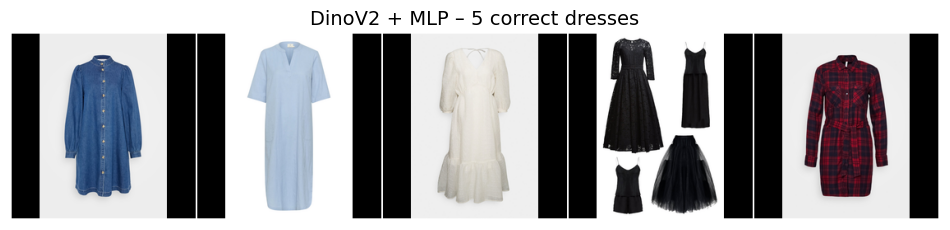

Dress Classifications
1º ✓ casual_dress
2º ✓ casual_dress
3º ✓ casual_dress
4º ✓ casual_dress
5º ✓ knitted_dress


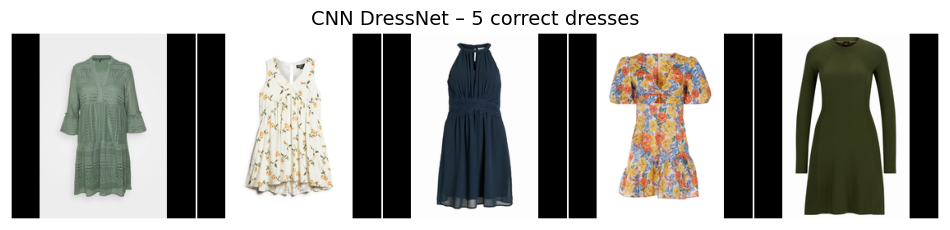

In [10]:
# Display
def show_grid(img_tensors, titles, nrow=5, figsize=(12,4), suptitle=""):
    imgs = torch.stack([denorm(t.cpu()) for t in img_tensors])
    grid = make_grid(imgs, nrow=nrow, pad_value=1)
    plt.figure(figsize=figsize)
    plt.imshow(to_pil_image(grid))
    plt.axis("off")
    if suptitle:
        plt.title(suptitle, fontsize=14)
    # Titles
    print("Dress Classifications")
    for i, t in enumerate(titles, 1):
        print(f"{i}º {t}")
    plt.show()

# === DinoV2 + MLP ===
show_grid([imgs_d[i] for i in d_hits_s],
          [f"✓ {idx_to_label[y_d_true[i].item()]}" for i in d_hits_s],
          suptitle="DinoV2 + MLP – 5 correct dresses")

# === Fine-tuned CNN ===
show_grid([imgs_cnn[i] for i in cnn_hits_s],
          [f"✓ {idx_to_label[y_c_true[i].item()]}" for i in cnn_hits_s],
          suptitle="CNN DressNet – 5 correct dresses")


- 5 images from the test set that were misclassified by the model.

Dress Classifications
1º ✗ true:evening_dress | pred:casual_dress
2º ✗ true:casual_dress | pred:jersey_dress
3º ✗ true:casual_dress | pred:jersey_dress
4º ✗ true:knitted_dress | pred:casual_dress
5º ✗ true:occasion_dress | pred:maxi_dress


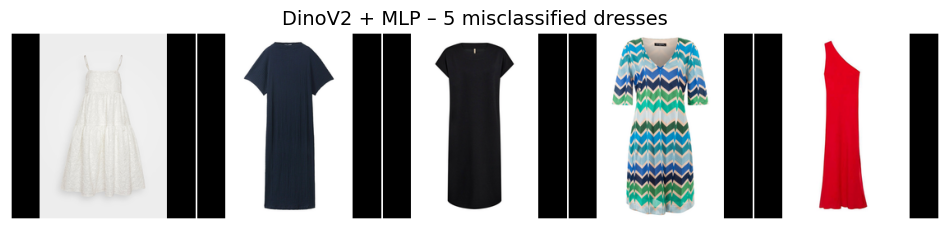

Dress Classifications
1º ✗ true:shift_dress | pred:shirt_dress
2º ✗ true:evening_dress | pred:occasion_dress
3º ✗ true:casual_dress | pred:shirt_dress
4º ✗ true:shift_dress | pred:evening_dress
5º ✗ true:shift_dress | pred:knitted_dress


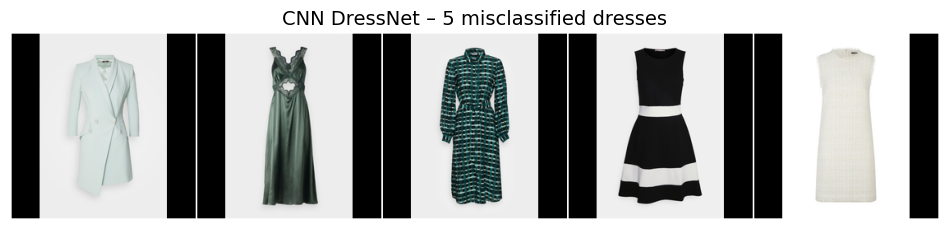

In [11]:

show_grid([imgs_d[i] for i in d_miss_s],
          [f"✗ true:{idx_to_label[y_d_true[i].item()]} | pred:{idx_to_label[y_d_pred[i].item()]}"
           for i in d_miss_s],
          suptitle="DinoV2 + MLP – 5 misclassified dresses")



show_grid([imgs_cnn[i] for i in cnn_miss_s],
          [f"✗ true:{idx_to_label[y_c_true[i].item()]} | pred:{idx_to_label[y_c_pred[i].item()]}"
           for i in cnn_miss_s],
          suptitle="CNN DressNet – 5 misclassified dresses")

- For the misclassified examples, try to understand why the model might
have made the mistake.
- Are there common visual patterns in the misclassified images for a
particular category?
- Are the images inherently ambiguous (i.e., even a human might struggle)?
- Does one model (DinoV2+MLP vs. CNN) seem to struggle with different
types of errors than the other? 

The dress counts start left to right and up to down:
1. Dresses 2 and 3 are both miss-classified as jersey dresses while presenting similar colors, shape and texture. Something similar happens for dresses 6,9 and 10, which are miss-classified, while all having "shift dress" as the true label. Furthermore, the resolution is not high enough to identify the texture patterns for identifying knitted dresses correctly. For example, picture 4 has a colorful pattern that does not allow to distinguish the texture of the cloth. 
2. We can see that some dresses in the dataset are ambiguous like in the 1st, 5th, 7th dresses, as they could be in different categories at the same time. Some of the categories themselves are also ambiguous, such as "casual dresses", which is more of a functional category rather than a visual one. In addition, e.g. the true classification of dress number 6 is most probably wrong. In general terms we can say that the classification system is not exhaustive and mutually exclusive enough. Lastly, the dresses 1,6 and 10 are very light coloured, making it hard to distinguish them from the background.
3. With help of the confusion matrix and the correctly classified elements we can notice that the fine-tuned CNN "DressNet" model is better at classifying elements belonging to the "casual dress" category, which is the most broad of all categories. On the other hand, we can notice that it over-classifies elements into that same category and has therefore worse performance in the more rare categories (such as "shift dress"), such as the ones shown directly above. Conversely, the DinoV2 model finds more balance among categories, miss-classifying more dresses that belong to the biggest category but achieving better results in the rest of categories.